In [1]:
import os
import requests
import json
import warnings
from warnings import filterwarnings
filterwarnings(action="ignore")
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [2]:
filename = "MTN.json"

In [3]:
def wrangle(filename:str, key:str, train_size:float= 0.8,*args) -> dict:
    '''Written strictly to deal with data extracted using AlphaVantage API's.
    Not for general use. Designed to deal with stock price data and present it in a usable(DataFrame)
    condition.
    Parameters:
    --------------------
            filename: str -> The file in question. Must be json.
            train_size: float(optional) -> The size of data kept for training
            key: str: The relevant key header in the file

    Returns-> dictionary of training data(closing stock prices) and test data

            '''
    with open(filename) as f:
        data = json.load(f)

    # Identifying relevant keys and values for extraction
    # Conversion of data to a DataFrame and transposition to allow for easier manipulation
    # df_comp = pd.DataFrame(data["Time Series (Daily)"]).T
    df_comp = pd.DataFrame(data[key]).T
    # Conversion of 'Object' types to float
    for i in df_comp.columns:
        df_comp[i] = df_comp[i].astype(float)
    df_comp = df_comp[::-1]

    df_comp.rename(
        columns={"4. close": "close", "1. open": "open", "2. high": "high", "3. low": "low", "5. volume": "volume"},
        inplace=True)
    df = df_comp.copy()
    df["dates"] = df.index
    df_comp["dates"] = df_comp.index

    df.dates = pd.to_datetime(df.dates, yearfirst=True)
    df.set_index("dates", inplace=True)
    df = df.asfreq('b')
    df.fillna(method="ffill", inplace=True)

    df_comp.dates = pd.to_datetime(df_comp.dates, yearfirst=True)
    df_comp.set_index("dates", inplace=True)
    df_comp = df_comp.asfreq('b')
    df_comp.fillna(method="ffill", inplace=True)

    df_ = df_comp.copy()


    size = int(train_size * len(df))
    df_train = df.iloc[:size]
    df_test = df.iloc[size:]

    frames = {"train": df_train, "test": df_test, "copy": df_}

    return frames


In [4]:
#output = wrangle(filename)
output = wrangle(filename, "Time Series (Daily)")

In [5]:
df_train = output["train"]

In [6]:
len(df_train)

82

In [7]:
class MovingAverageCalculator:
    '''Code base for a moving average calculator. Computes moving averages on a time series
    stock price dataset
    Parameters:
    -------------
    prices: str-> The relevant filename containing the preprocessed time series data.'''
    
    def __init__(self, prices):
        self.prices = prices
        self.__sma = []

    @property
    def sma(self):
        return self.__sma

    def moving_averages(self, window:int, type:str) -> dict:
        '''
        Returns DataFrame of given dataset and the moving averages as specified.
        Parameters:
        -----------------
        window: int -> Moving average window
        type: str -> One of "high", "low", "open" or "close" prices
        :return: Dictionary:
        keys : values
        Data : DataFrame of formatted TS data and moving average values
        Buy_values : Bull values
        Buy_dates : Bull dates
        Sell_values: Bear values
        Sell_dates : Sell dates
        
        '''
        buy_dates = []
        buy_values = []
        sell_dates = []
        sell_values = [] 
        results = {}
        for i in range(len(self.prices) - window + 1):
            avg = np.mean(self.prices[type][i:i + window])
            self.__sma.append(avg)
        self.prices = self.prices.iloc[window - 1:]
        for i in range(1, len(self.prices)):
            if self.prices[type].iloc[i-1] < self.__sma[i-1] and self.prices[type].iloc[i] > self.__sma[i]:
                buy_dates.append(self.prices.index[i])
                buy_values.append(self.prices[type].iloc[i])
            elif self.prices[type].iloc[i-1] > self.__sma[i-1] and self.prices[type].iloc[i] < self.__sma[i]:
                sell_dates.append(self.prices.index[i])
                sell_values.append(self.prices[type].iloc[i])
            
        self.prices[f"{type} MA {window}"] = self.__sma
        results["Data"] = self.prices
        results["Buy_values"] = buy_values
        results["Buy_dates"] = pd.to_datetime(buy_dates)
        results["Sell_dates"] = pd.to_datetime(sell_dates)
        results["Sell_values"] = sell_values
        

        return results


In [8]:
df_train.iloc[2]

open          5.04
high          5.12
low           5.00
close         5.00
volume    36744.00
Name: 2024-04-09 00:00:00, dtype: float64

In [9]:
results = MovingAverageCalculator(df_train)

In [10]:
data = results.moving_averages(3, "open")

In [11]:
df = data["Data"]

In [12]:
df

,open,high,low,close,volume,open MA 3
dates,,,,,,
2024-04-09,5.0400,5.1200,5.0000,5.0000,36744.0,5.140000
2024-04-10,5.0000,5.0000,4.9200,4.9200,36685.0,5.056667
2024-04-11,4.9700,5.0100,4.9000,4.9740,28702.0,5.003333
2024-04-12,4.8150,4.8700,4.7900,4.7900,18712.0,4.928333
2024-04-15,4.7500,4.7500,4.5700,4.5840,19093.0,4.845000
...,...,...,...,...,...,...
2024-07-23,4.0800,4.2200,4.0800,4.2200,40590.0,4.103467
2024-07-24,4.2450,4.2450,4.1584,4.1584,34556.0,4.148333
2024-07-25,4.1108,4.2800,4.1108,4.2800,183019.0,4.145267


In [13]:
sell_dates, sell_values, buy_dates, buy_values = data['Sell_dates'],  data['Sell_values'], data['Buy_dates'], data['Buy_values']

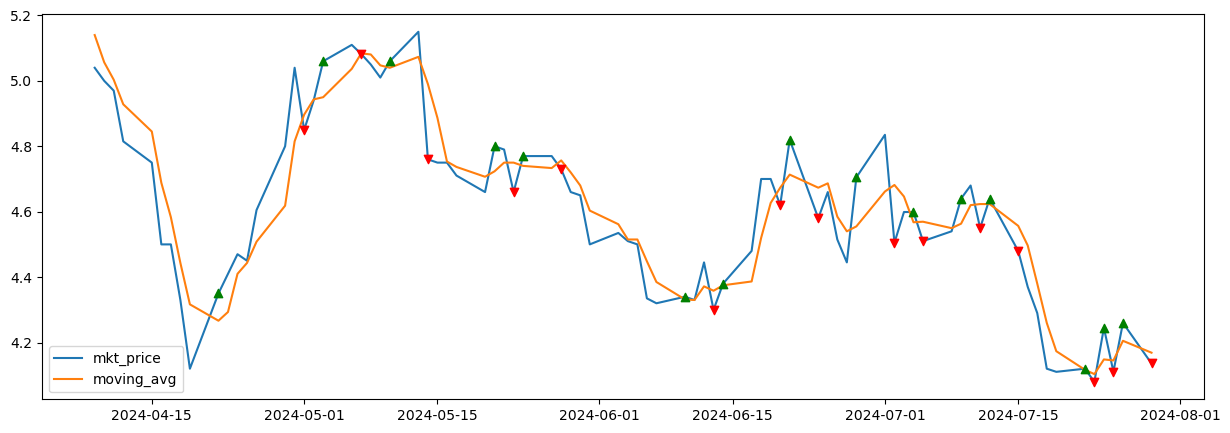

In [19]:
plt.figure(figsize=(15, 5))
plt.plot(df[["open", "open MA 3"]])
plt.legend(labels=["mkt_price", "moving_avg"], loc="lower left")
plt.scatter(sell_dates, sell_values, marker='v', color="red", zorder=5)
plt.scatter(buy_dates, buy_values, marker='^', color="green", zorder=5);

In [16]:
fig = go.Figure()

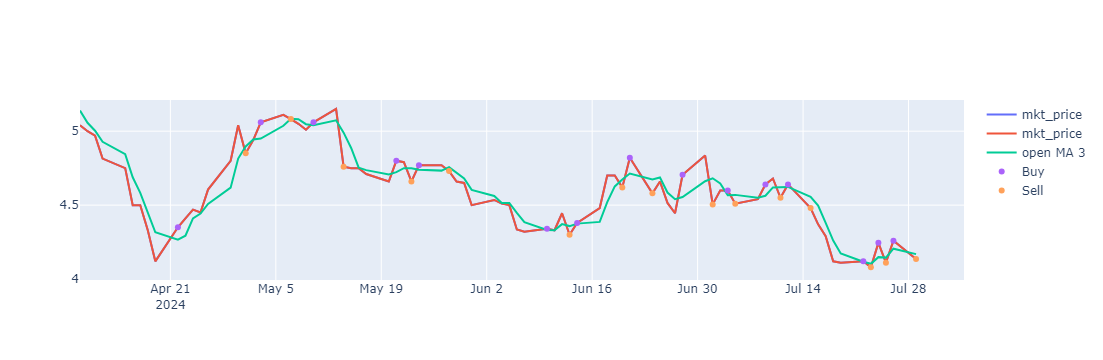

In [20]:
fig.add_trace(go.Scatter(x=df.index, y=df.open, name="mkt_price"))
fig.add_trace(go.Scatter(x=df.index, y=df["open MA 3"], name="open MA 3"))
fig.add_trace(go.Scatter(x=buy_dates, y=buy_values, mode="markers", name="Buy"))
fig.add_trace(go.Scatter(x=sell_dates, y=sell_values, mode="markers", name="Sell"))

In [ ]:
len(df.index)

In [ ]:
len(df.mkt_price)

In [ ]:
df[df.columns[-1]]

In [ ]:
df

In [ ]:
len(df.index)

In [ ]:
len(df)